<a href="https://colab.research.google.com/github/samsoe/mpg_notebooks/blob/master/abundance_order_habitat_wrangle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# View: abundance_order_habitat
Project:Dataset in BQ: **mpg-data-warehouse:bird_point_count_summaries**

This view will allow us to analyze basic trends in bird abundance among habitats at MPG. Initially, such summaries are necessary for the MPG Matrix. To produce the view, the bird data must first be summarized to obtain abundances by taxonomic order at each grid point. There will be several steps to consider how to account for the number of technician visits per year and the number of points visited per year. Then, the summarized bird data will be joined to a habitat classification from grid point metadata.

* Documentation: [Readme bird point count monitoring](https://docs.google.com/document/d/1PRryJzGOUtfr-fKXzb3tbr48xiaTuAMVk18XFXlvxcM/edit?usp=sharing)

## Updates will be necessary
* **2020-05-22**. Right now, this file must pull data from a csv in GD, rather than a view in BQ as intended. This is due to an [OAuth issue](https://colab.research.google.com/drive/1NkqB9RXRpMl2m4fwTy3H5rz1SDwCA_DE#scrollTo=EIn9rVWbwOMo&line=1&uniqifier=1) that we are looking into. Make sure that we evenually circle back and confirm that this notebook is pulling data from BQ, whether we have to flatten the source files, or if we learn how to manage GD OAuth.
* **2020-05-22**. Right now, abundance summaries for the MPG Matrix are processed in this notebook. Once we are able to solve the issue from (1), move the abundance summaires to a new notebook located in the Matrix directory. 

# Tools
* Remember that the file containing authorization keys for Big Query must be loaded into the virutual envrionment manually.

In [0]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [0]:
install.packages("bigrquery")
library(bigrquery)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bit’, ‘bit64’, ‘gargle’, ‘rapidjsonr’




# Source

## BigQuery

### Database Connection

In [0]:
# BigQuery API Key
bq_auth(path = "/content/mpg-data-warehouse-api_key-master.json")

In [0]:
Sys.setenv(BIGQUERY_TEST_PROJECT = "mpg-data-warehouse")

In [0]:
billing <- bq_test_project()

In [0]:
con_bird_point_counts <- dbConnect(
  bigrquery::bigquery(),
  project = "mpg-data-warehouse",
  dataset = "bird_point_counts",
  billing = billing
)

In [0]:
con_location_position_classification <- dbConnect(
    bigrquery::bigquery(),
  project = "mpg-data-warehouse",
  dataset = "grid_point_summaries",
  billing = billing
)

In [0]:
dbListTables(con_bird_point_counts)

[1] "bird_surveyInfo_records_function" "bird_survey_noise"               
[3] "bird_survey_sky"                  "bird_survey_wind"

In [0]:
dbListTables(con_location_position_classification)

[1] "location"                         "location_position_classification"
[3] "point_location_position"

### Query Database

#### bird_point_counts

In [0]:
bird_sql <- "SELECT *
             FROM `mpg-data-warehouse.bird_point_counts.bird_surveyInfo_records_function`"

In [0]:
# result bird table
bq_bird <- bq_project_query(billing, bird_sql)

In [0]:
tb_bird = bq_table_download(bq_bird)

In [0]:
class(tb_bird)

[1] "tbl_df"     "tbl"        "data.frame"

In [0]:
df_bird <- as.data.frame(tb_bird)

In [0]:
str(df_bird)

'data.frame':	117810 obs. of  31 variables:
 $ survey_ID                         : int  4915 4915 4915 4915 4915 4915 4915 4915 4915 4915 ...
 $ survey_year                       : int  2013 2013 2013 2013 2013 2013 2013 2013 2013 2013 ...
 $ survey_date                       : Date, format: "2013-06-17" "2013-06-17" ...
 $ survey_visit_calc                 : int  2 2 2 2 2 2 2 2 2 2 ...
 $ survey_time_start_MDT             : 'hms' num  08:27:00 08:27:00 08:27:00 08:27:00 ...
  ..- attr(*, "units")= chr "secs"
 $ survey_time_end_MDT               : 'hms' num  08:37:00 08:37:00 08:37:00 08:37:00 ...
  ..- attr(*, "units")= chr "secs"
 $ survey_grid_point                 : int  179 179 179 179 179 179 179 179 179 179 ...
 $ survey_observer                   : chr  "Katharine Stone" "Katharine Stone" "Katharine Stone" "Katharine Stone" ...
 $ survey_wind_code                  : int  3 3 3 3 3 3 3 3 3 3 ...
 $ survey_sky_code                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ survey_noise

#### location_position_classification

In [0]:
location_sql <- "SELECT *
                 FROM `mpg-data-warehouse.grid_point_summaries.location_position_classification`"

Leave the following error for now.  To move forward in the present output csv from table `mpg-data-warehouse.grid_point_summaries.location_position_classification`

In [0]:
bq_location <- bq_project_query(billing, location_sql)

ERROR: ignored

## CSV

### location_position_classification

In [0]:
# MPG Ranch Datasets > Bird point count monitoring > Data - Processed > location_position_classification.csv
src_location = "https://drive.google.com/uc?id=1z1nFdsk0vZXhw78rB3ijrFcLX2mF4VBQ"
df_location <- read_csv(src_location)

Parsed with column specification:
cols(
  grid_point = col_double(),
  lat = col_double(),
  long = col_double(),
  aspect_mean_deg = col_double(),
  elevation_mean_m = col_double(),
  slope_mean_deg = col_double(),
  cover_type_2016_gridVeg = col_character(),
  biomass_habitat_type = col_character(),
  type1_biome = col_character(),
  type2_vegetation_community = col_character(),
  type3_vegetation_indicators = col_character(),
  type4_indicators_history = col_character()
)



# Structure

## bird_point_counts
In general, make sure any user is familiar with the data entry protocol before summarizing these data. Many grouping and summarizing steps are often necessary to properly examine these data. 

* When correcting for survey effort, we need to divide the annual sums by the number of survey visits. In almost all cases, visits = 2, so dividing by 2 is probably sufficient. However, a more robust approach would be to create a "total visits" variable and use that to calculate averages. This is the approach we used.
* There are 218 missing records in `function_taxa_order` that result from the bird records summary below. They result from the various "unknown bird" designations possible in the species list, and are acceptable to disregard. 
* There are 21 missing records in `records_abundance`, but these are eliminated using the sum() function in the first summary. 
* 2020-05-25 BL performed a quick diagnostic to test the summary produced here. The number of grid points surveyed per year matched what was found in the wrangle notebook [here](https://colab.research.google.com/drive/1iOF9P-cfzE4-A7KA2M3xJ7zXmSZnuUSe#scrollTo=kSANOTDWLRgU&line=8&uniqifier=1), which is some supporting evidence that all data were recovered in this summary. 

In [0]:
# Total visits per year
df_visits <-
  df_bird %>% 
  group_by(survey_year, survey_grid_point) %>% 
  summarize(survey_visits_total = max(survey_visit_calc)) %>% glimpse()

Rows: 4,157
Columns: 3
Groups: survey_year [10]
$ survey_year         <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2…
$ survey_grid_point   <int> 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 1…
$ survey_visits_total <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2…


In [0]:
# Abundance summary
bird_abundance <- df_bird %>%
  filter(records_detect_distance_min_meters <= 100,
         records_interval %in% c(1, 2)) %>%
  group_by(survey_year, survey_visit_calc, survey_grid_point, function_taxa_order) %>%
  summarize(bird_abundance_survey = sum(records_abundance, na.rm = TRUE)) %>%
  group_by(survey_year, survey_grid_point, function_taxa_order) %>%
  summarize(bird_abundance_sum = sum(bird_abundance_survey, na.rm = TRUE)) %>%
  ungroup() %>%  
  left_join(df_visits) %>% 
  drop_na() %>%
  mutate(bird_abundance_avg = bird_abundance_sum / survey_visits_total) %>% 
  select(-survey_visits_total, -bird_abundance_sum) %>% 
  glimpse()

Joining, by = c("survey_year", "survey_grid_point")



Rows: 7,068
Columns: 4
$ survey_year         <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2…
$ survey_grid_point   <int> 1, 1, 1, 2, 2, 3, 3, 4, 4, 6, 7, 7, 7, 8, 8, 9, 9…
$ function_taxa_order <chr> "Accipitriformes", "Galliformes", "Passeriformes"…
$ bird_abundance_avg  <dbl> 0.5, 0.5, 17.0, 1.0, 7.0, 0.5, 8.0, 0.5, 5.5, 7.5…


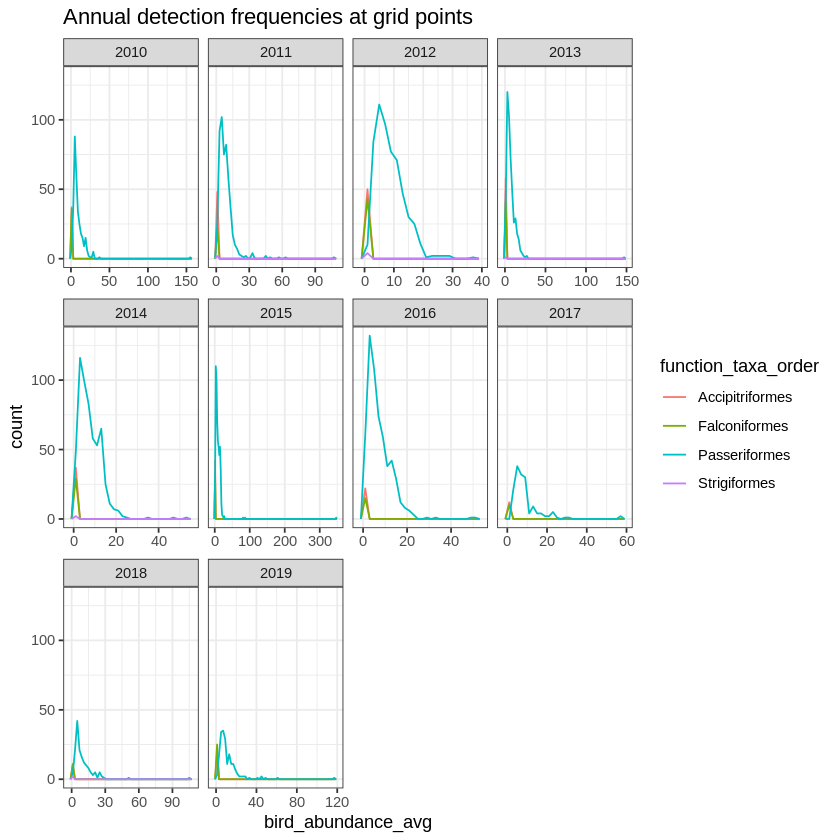

In [0]:
bird_abundance %>% 
filter(function_taxa_order %in% c("Passeriformes", "Accipitriformes", "Falconiformes", "Strigiformes")) %>% 
ggplot(aes(x = bird_abundance_avg)) +
geom_freqpoly(aes(color = function_taxa_order), center = 1, binwidth = 2) +
facet_wrap(vars(survey_year), scales = "free_x") +
labs(title = "Annual detection frequencies at grid points") +
theme_bw()

# Join tables
Join **grid point metadata** and **bird records** with selected columns to produce the desired view: **abundance_order_habitat**

* 2020-05-22 BL initial diagnostics on this look good




In [0]:
bird_abundance %>% 
glimpse()

Rows: 7,068
Columns: 4
$ survey_year         <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2…
$ survey_grid_point   <int> 1, 1, 1, 2, 2, 3, 3, 4, 4, 6, 7, 7, 7, 8, 8, 9, 9…
$ function_taxa_order <chr> "Accipitriformes", "Galliformes", "Passeriformes"…
$ bird_abundance_avg  <dbl> 0.5, 0.5, 17.0, 1.0, 7.0, 0.5, 8.0, 0.5, 5.5, 7.5…


In [0]:
df_location %>% 
glimpse()

Rows: 582
Columns: 12
$ grid_point                  <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…
$ lat                         <dbl> 46.73193, 46.72972, 46.72443, 46.72487, 4…
$ long                        <dbl> -114.0017, -114.0010, -114.0227, -114.019…
$ aspect_mean_deg             <dbl> 334.7050, 45.3030, 221.3340, 290.4890, 28…
$ elevation_mean_m            <dbl> 1395.64, 1456.09, 1126.90, 1166.33, 1179.…
$ slope_mean_deg              <dbl> 28.44230, 12.22630, 4.25130, 2.68361, 4.2…
$ cover_type_2016_gridVeg     <chr> "woodland/forest", "non-irrigated grassla…
$ biomass_habitat_type        <chr> NA, "Range", "Range", "Range", "Range", "…
$ type1_biome                 <chr> "forest", "rangeland", "rangeland", "rang…
$ type2_vegetation_community  <chr> "upland", "grassland", "grassland", "gras…
$ type3_vegetation_indicators <chr> "mixed canopy conifer", "uncultivated gra…
$ type4_indicators_history    <chr> "mixed canopy conifer", "uncultivated gra…


In [0]:
abundance_order_habitat <-
bird_abundance %>% 
  left_join(df_location %>% select(grid_point, starts_with("cover"), starts_with("biomass"), starts_with("type")), 
            by = c("survey_grid_point" = "grid_point")) %>%
  glimpse()

Rows: 7,068
Columns: 10
$ survey_year                 <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010,…
$ survey_grid_point           <dbl> 1, 1, 1, 2, 2, 3, 3, 4, 4, 6, 7, 7, 7, 8,…
$ function_taxa_order         <chr> "Accipitriformes", "Galliformes", "Passer…
$ bird_abundance_avg          <dbl> 0.5, 0.5, 17.0, 1.0, 7.0, 0.5, 8.0, 0.5, …
$ cover_type_2016_gridVeg     <chr> "woodland/forest", "woodland/forest", "wo…
$ biomass_habitat_type        <chr> NA, NA, NA, "Range", "Range", "Range", "R…
$ type1_biome                 <chr> "forest", "forest", "forest", "rangeland"…
$ type2_vegetation_community  <chr> "upland", "upland", "upland", "grassland"…
$ type3_vegetation_indicators <chr> "mixed canopy conifer", "mixed canopy con…
$ type4_indicators_history    <chr> "mixed canopy conifer", "mixed canopy con…


Rows: 174
Columns: 4
$ survey_year                 <int> 2010, 2010, 2010, 2010, 2010, 2010, 2010,…
$ function_taxa_order         <chr> "Accipitriformes", "Accipitriformes", "Ac…
$ type3_vegetation_indicators <chr> "former cultivated", "mixed sage and bitt…
$ abundance_avg               <dbl> 0.7000000, 0.7000000, 0.8125000, 0.500000…


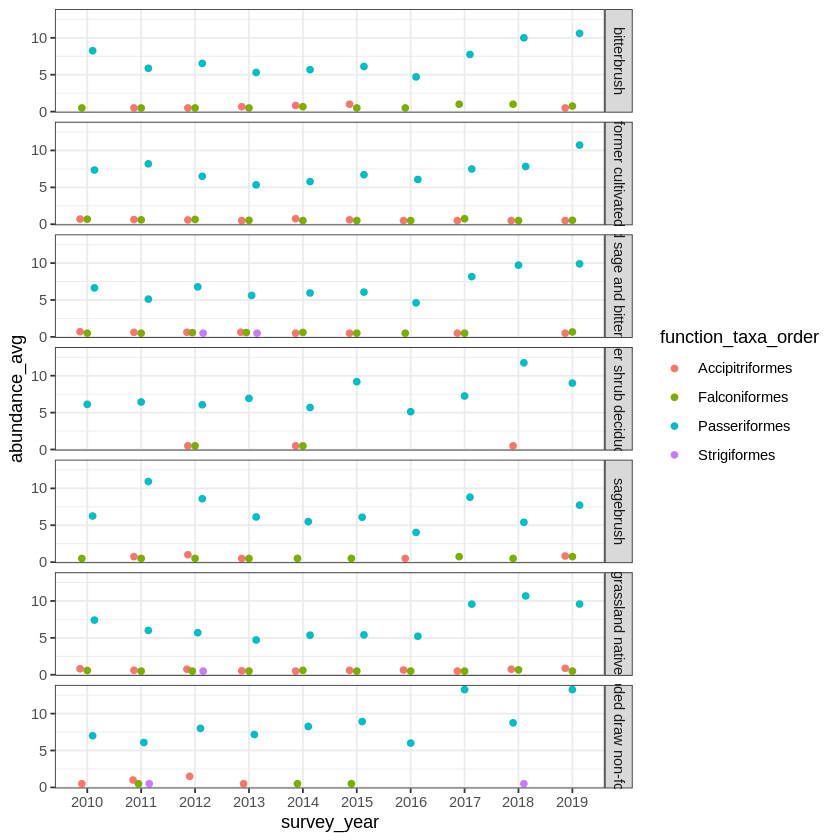

In [0]:
abundance_order_habitat %>% 
filter(type2_vegetation_community %in% c("grassland", "shrubland"),
       function_taxa_order %in% c("Passeriformes", "Accipitriformes", "Falconiformes", "Strigiformes")) %>% 
group_by(survey_year, function_taxa_order, type3_vegetation_indicators) %>% 
summarize(abundance_avg = mean(bird_abundance_avg)) %>% 
ungroup() %>% 
glimpse() %>% 
mutate(survey_year = as.factor(survey_year)) %>% 
ggplot(aes(x = survey_year, y = abundance_avg, color = function_taxa_order)) +
geom_point(position = position_dodge(width = 0.4)) +
#geom_dotplot(aes(fill = function_taxa_order), binaxis = "y", method = "histodot", stackdir = "center", binwidth = 2.5) +
facet_grid(rows = vars(type3_vegetation_indicators)) + 
theme_bw()

# A tibble: 423 x 4
   survey_year function_taxa_ord… type3_vegetation_indicators      abundance_avg
         <int> <chr>              <chr>                                    <dbl>
 1        2010 Accipitriformes    former cultivated                        0.7  
 2        2010 Accipitriformes    mixed sage and bitterbrush               0.7  
 3        2010 Accipitriformes    uncultivated grassland native o…         0.812
 4        2010 Accipitriformes    wooded draw non-forest                   0.5  
 5        2010 Anseriformes       former cultivated                        0.75 
 6        2010 Anseriformes       uncultivated grassland native o…         1    
 7        2010 Caprimulgiformes   bitterbrush                              1    
 8        2010 Caprimulgiformes   mixed sage and bitterbrush               0.5  
 9        2010 Caprimulgiformes   uncultivated grassland native o…         0.5  
10        2010 Charadriiformes    former cultivated                        1.06 
11      

# Matrix